<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [23]:
# librerias
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
from scipy.stats import beta
import pylab as plt
import bayes as bayes
from scipy.stats import ttest_ind

In [4]:
# datos
cookie = pd.read_csv('data/cookie_cats.csv')
cookie

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [5]:
# transformacion
'''en un principio pensaba eliminar las filas que correspondiesen a jugadores que no habían jugado ronda alguna
 pero después decidí no hacerlo pues no creo que cambie significativamente los resultados'''
cookie['sum_gamerounds'].value_counts().get(0)

3994

In [ ]:
# hecho 'a mi manera' buscando en google

In [8]:
# muestreo
'''creo un dataframe control con los datos filtrados del grupo de control gate_30'''
control = cookie[cookie['version'] == 'gate_30']
'''creo un dataframe test  con los datos filtrados del grupo de testeo gate_40'''
test = cookie[cookie['version'] == 'gate_40']

In [9]:
# testeo para retention_1

# para grupo control
# numero de conversiones y no conversiones
'''sumo todos los valores de la columna 'retention_1' del DataFrame control y obtengo el número total de 
jugadores que regresaron y jugaron 1 día después de la instalación.'''
conversions_control_1 = control['retention_1'].sum()

'''resto el número de conversiones y obtengo el número de jugadores que no regresaron para jugar 1 día 
después de la instalación.'''
non_conversions_control_1 = control['retention_1'].count() - conversions_control_1

#distribucion beta
'''creo una distribución beta introduciendo el número de conversiones y no conversiones como parámetros. 
 Añado 1 a cada parámetro para evitar errores de cálculo cuando el número de conversiones o no conversiones es 0.'''
beta_control_1 = beta(conversions_control_1 + 1, non_conversions_control_1 + 1)

# para test
# numero de conversiones y no conversiones
conversions_test_1 = test['retention_1'].sum()
non_conversions_test_1 = test['retention_1'].count() - conversions_test_1

#distribucion beta
beta_test_1 = beta(conversions_test_1 + 1, non_conversions_test_1 + 1)

#testeo retention_1
'''calculo la probabilidad de que la tasa de retención a 1 día del grupo test sea mayor que la del 
grupo de control.'''
prob_retention_1 = bayes.calc_prob(beta_test_1, beta_control_1)

In [20]:
beta_control_1.mean(), beta_test_1.mean()

(0.44819023757326293, 0.44228528719966587)

In [10]:
# testeo para retention_7

# control
# Calcular el número de conversiones y no conversiones
conversions_control_7 = control['retention_7'].sum()
non_conversions_control_7 = control['retention_7'].count() - conversions_control_7
#distribucion beta
beta_control_7 = beta(conversions_control_7 + 1, non_conversions_control_7 + 1)

# test
# numero de conversiones y no conversiones
conversions_test_7 = test['retention_7'].sum()
non_conversions_test_7 = test['retention_7'].count() - conversions_test_7
#distribucion beta
beta_test_7 = beta(conversions_test_7 + 1, non_conversions_test_7 + 1)

#testeo retention_7
prob_retention_7 = bayes.calc_prob(beta_test_7, beta_control_7)

In [21]:
beta_control_7.mean(), beta_test_7.mean()

(0.19021520289919913, 0.18201402475214878)

In [12]:
# conclusiones

print('probabilidad de retencion a 1 día:', prob_retention_1)
print('probabilidad de retencion a 7 días:', prob_retention_7)


# Explica detalladamente las conclusiones obtenidas de. tu testeo.
'''un valor de probabilidad de 1 significa que estamos completamente seguros de que un evento ocurrirá, 
mientras que un valor de 0 significa que estamos completamente seguros de que el evento no ocurrirá. 
Los valores entre 0 y 1 representan grados de certeza. Por ejemplo, una probabilidad de 0.5 significa que 
creemos que el evento es igualmente probable que ocurra o no ocurra.'''

probabilidad de retencion a 1 día: 0.037206025180329845
probabilidad de retencion a 7 días: 0.0007773386645759051


'un valor de probabilidad de 1 significa que estamos completamente seguros de que un evento ocurrirá, \nmientras que un valor de 0 significa que estamos completamente seguros de que el evento no ocurrirá. \nLos valores entre 0 y 1 representan grados de certeza. Por ejemplo, una probabilidad de 0.5 significa que \ncreemos que el evento es igualmente probable que ocurra o no ocurra.'

In [ ]:
# siguiendo los pasos de los apuntes de clase

In [32]:
cookie.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [33]:
gate_40 = 45489
gate_30 = 44700

In [34]:
gate_30_retention1 = cookie[(cookie['version'] == 'gate_30') & (cookie['retention_1'] == True)].shape[0]
gate_40_retention1 = cookie[(cookie['version'] == 'gate_40') & (cookie['retention_1'] == True)].shape[0]
gate_30_retention7 = cookie[(cookie['version'] == 'gate_30') & (cookie['retention_7'] == True)].shape[0]
gate_40_retention7 = cookie[(cookie['version'] == 'gate_40') & (cookie['retention_7'] == True)].shape[0]

In [36]:
# los datos son conocidos : impresiones y conversiones para test y control

imps_ctrl, convs_ctrl = gate_30, gate_30_retention1  

imps_test, convs_test = gate_40 , gate_40_retention1 


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas retencion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas retencion: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [37]:
# a prioris

a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [39]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [40]:
x=np.linspace(0.43, 0.47, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

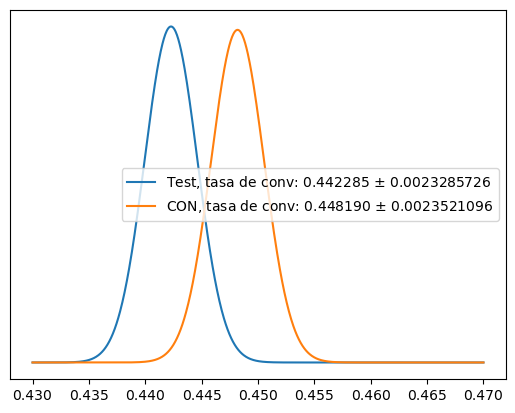

In [41]:
plot([beta_test, beta_control], ['Test', 'CON'])

In [42]:
# lo mismo para retention 7

In [43]:
# los datos son conocidos : impresiones y conversiones para test y control

imps_ctrl, convs_ctrl = gate_30, gate_30_retention7  

imps_test, convs_test = gate_40 , gate_40_retention7 


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas retencion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas retencion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [44]:
# a prioris

a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [45]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [46]:
x=np.linspace(0.17, 0.20, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

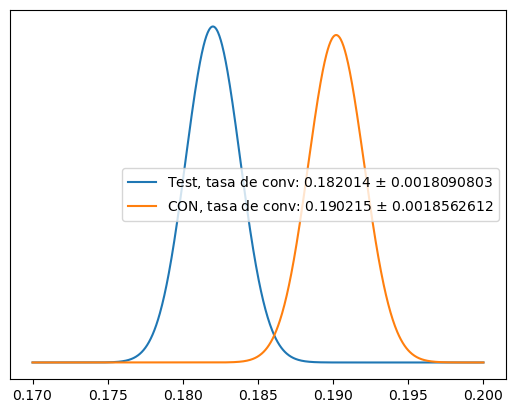

In [47]:
plot([beta_test, beta_control], ['Test', 'CON'])

In [48]:
#ttest

In [49]:
# para la retención a 1 día
stat_1, pvalue_1 = ttest_ind(control['retention_1'], test['retention_1'])
stat_1, pvalue_1

(1.7840979256519656, 0.07441111525563184)

In [50]:
'''no hay diferencia significativa en la retencion a 1 dia entre el grupo test y el grupo control'''

'no hay diferencia significativa en la retencion a 1 dia entre el grupo test y el grupo control'

In [51]:
# para la retención a 7 días
stat_7, pvalue_7 = ttest_ind(control['retention_7'], test['retention_7'])
stat_7, pvalue_7

(3.1644994996802778, 0.0015540151201088365)

In [52]:
'''hay diferencia significativa en la retencion a 1 dia entre el grupo test y el grupo control'''

'hay diferencia significativa en la retencion a 1 dia entre el grupo test y el grupo control'

In [53]:
# conclusión
'''pasar la la puerta del nivel 30 al nivel 40 no tiene un impacto significativo en la retención a 1 día, 
pero sí tiene un impacto significativo en la retención a 7 días'''

'pasar la la puerta del nivel 30 al nivel 40 no tiene un impacto significativo en la retención a 1 día, \npero sí tiene un impacto significativo en la retención a 7 días'